In [1]:
import pickle
import radvel
import rebound as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy import optimize, stats
import corner
from radvel.plot import mcmc_plots
import reboundx
import emcee
from multiprocessing import Pool
import h5py
import time
from celmech.nbody_simulation_utilities import align_simulation
from tqdm import tqdm
from rebound.interruptible_pool import InterruptiblePool

/home/ianchow/.local/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


Importing the data:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data.BJD -= 2.4e6

Previously found parameters (including RV offset and sin_i in that order at the end, but NOT jitter):

In [3]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 
               1.17923823e-01,  3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 
               1.68408461e-01,  5.05903191e-02, -3.28526403e-03, 1]

#Least squares fit: 
fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
               -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
               9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 1]#-7.68527759e-03] 


Take star mass as given constant:

In [4]:
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

obs_time_base = np.median(hd_data.BJD)

In [5]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass=STAR_MASS, auday_ms=AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters

    param params: numpy array of params:

    for i in range(0, num_planets):

    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)

    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)

    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """

    num_planets = int((len(params) - 1) / 5)  # -2 because there are rv_offset and jit parameters:

    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1 / 50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m=star_mass)  # star mass as a constant

    inclination = np.arcsin(params[-1])  # sin(i) is at the back of the array

    for i in range(0, num_planets):
        # print(i)
        # planet parameters
        period = params[5 * i]  # in days
        semiamp = params[5 * i + 1] / auday_ms  # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5 * i + 3] ** 2 + params[5 * i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5 * i + 3], params[5 * i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5 * i + 2], per=period, ecc=eccentricity, omega=omega)

        # mass
        mass = semiamp_to_mass(semiamp=semiamp, star_mass=star_mass, period=period, eccentricity=eccentricity,
                               inclination=inclination)

        # adding to simulation
        sim.add(m=mass, P=period, e=eccentricity, T=tp, omega=omega, inc=inclination)

    sim.move_to_com()  # move to center of mass

    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i) (also params[-2])
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    sim = get_sim_from_params(params, integrator, time_base=time_base)

    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))

    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))

    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed

    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time=1)
        # integrate to the specified time, exact_finish_time = 1 for ias15,
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s

    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time=1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]

    return np.concatenate((rv_backward, rv_forward))

Compute residuals and then use `optimize.least_squares`:

In [6]:
def get_nbody_resids(params, integrator, data = hd_data):
    """
    Gets the normalized residuals for the n-body fit with REBOUND
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.BJD, integrator, time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    return (obs_y - synth_y) / obs_yerr  # return normalized residuals

def neg_log_likelihood(params, data = hd_data):
    """
    Gets the negative log-likelihood (without a jitter term) for use with scipy.optimize.minimze
    
    Implements the log likelihood using the same method above
    
    """
    # LOG LIKELIHOOD
    obs_y = data.RV_mlc_nzp  # observed RVs
    
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    # # compute variance
    # variance = obs_yerr ** 2  # + (synth_y * np.exp(log_f)) ** 2  # assuming simply that variance is underestimated by some amount f

    # # # compute log likelihood
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))  # this is equivalent up to a 2pi constant
    
    # log_likelihood = -1 / 2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2 / variance))
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2) 
                                   + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2))))

    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood

Optimizing by minimizing negative log likelihood:

In [7]:
# OPTIMIZE USING OPTIMIZE.MINIMIZE WITH THE LOG LIKELIHOOD INSTEAD OF JUST NORMAL LEAST-SQUARES FIRST AND COMPARE

# bounds of (0, 1) for sin(i), everything else can vary however: bounds format for optimize.minimize()
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0, 1))

best_fit = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

# bounds format for optimize.least_squaares()
bounds2 = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1])  # bounds of [0, 1] for sin(i)
fit_params_chi2 = optimize.least_squares(lambda params: get_nbody_resids(params, integrator = 'ias15'), best_fit.x, bounds=bounds2)

Compare to original guess:

In [8]:
print(f'original guess:\n{np.array(fit_params)}\n\noptimization without jitter using negloglike:\n{best_fit.x}\n\optimization using ls and ias15:\n{best_fit.x}')

original guess:
[ 2.28512793e+02  7.27736501e+00  5.39371914e+04 -4.66868256e-02
 -1.78080009e-01  3.43378038e+02  1.78603341e+01  5.40186750e+04
  9.72945632e-02  1.32194117e-01 -5.29072002e-01  1.00000000e+00]

optimization without jitter using negloglike:
[ 2.27608549e+02  7.33035500e+00  5.39372431e+04 -1.00024238e-01
  1.45219770e-01  3.43742222e+02  1.78419992e+01  5.40164735e+04
  1.48456924e-01  1.47247942e-01 -4.94782591e-01  1.00000000e+00]
\optimization using ls and ias15:
[ 2.27608549e+02  7.33035500e+00  5.39372431e+04 -1.00024238e-01
  1.45219770e-01  3.43742222e+02  1.78419992e+01  5.40164735e+04
  1.48456924e-01  1.47247942e-01 -4.94782591e-01  1.00000000e+00]


In [9]:
mass_sim = get_sim_from_params(fit_params_chi2.x, integrator='ias15', time_base=obs_time_base)
mass_sim.particles[1].m, mass_sim.particles[2].m

(0.2006984753442282, 0.5643190464143741)

In [10]:
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))

Plot against original n-body parameters:

(-30.0, 28.890884374933037)

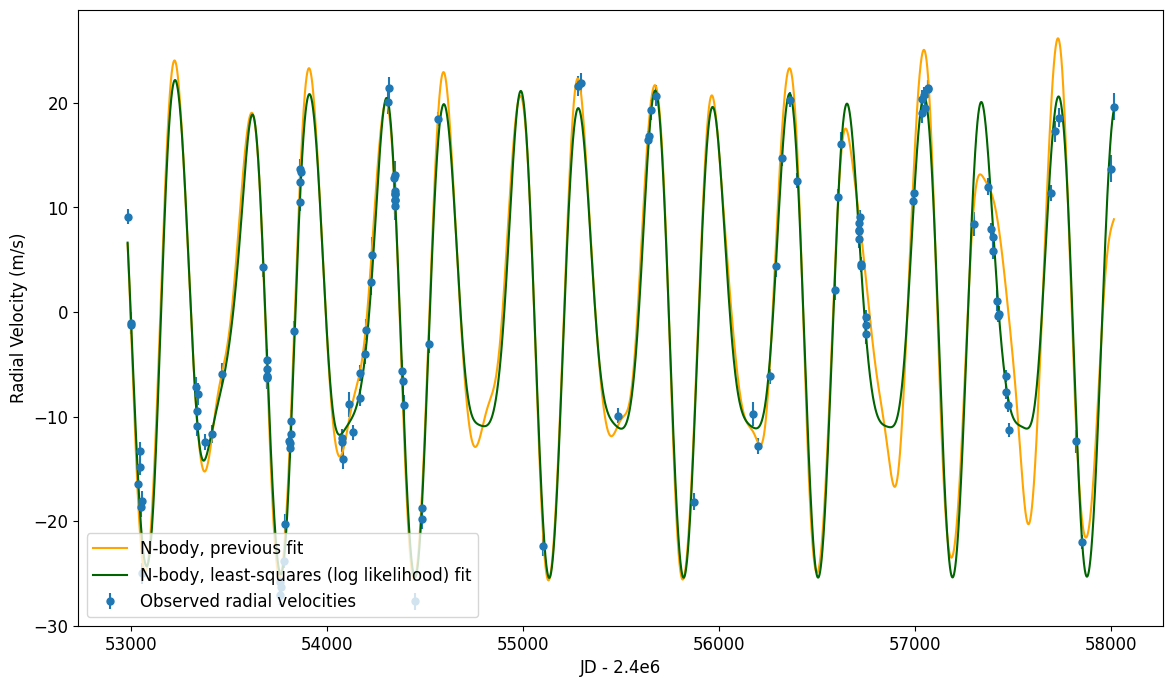

In [11]:
pl.figure(figsize=(14, 8))
pl.rc('font', size = 12)
# plot the observed RVs
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed radial velocities')
# plot the REBOUND n-body reuslt for original parameters and least-squares fit
pl.plot(times, get_rvs(nbody_params, times, 'ias15', time_base = obs_time_base), label = 'N-body, previous fit', color='orange')#, color='black')
pl.plot(times, get_rvs(fit_params_chi2.x, times, 'ias15', time_base = obs_time_base), label = 'N-body, least-squares (log likelihood) fit', color='darkgreen')#, color='orange')
# plot the Keplerian result
# pl.plot(times, post.model(times), label = 'Keplerian')
pl.legend(loc = 'lower left')
pl.xlabel('JD - 2.4e6'), pl.ylabel('Radial Velocity (m/s)')
pl.ylim(bottom = -30)
# pl.title('N-body least-squares fit vs. previous fit')
# pl.savefig('nbody_vs_prev.png', fmt = 'png', pad_inches = 0)

In [12]:
neg_log_likelihood(fit_params_chi2.x)

324.938372965956

In [13]:
np.linalg.inv(fit_params_chi2.jac.T @ fit_params_chi2.jac).shape

(12, 12)

In [14]:
def log_prior(params, e_max=0.8, sin_i_min=0.3):
    ps = params[0:-3:5]  # start at 0, the last 3 elements of params are not planet params (rv_offset, sin(i), jitter)
    ks = params[1:-3:5]  # semiamps
    tcs = params[2:-3:5]  # times of conjunction
    # compute e and omega from secos, sesin
    es = params[3:-3:5] ** 2 + params[4:-3:5] ** 2  # eccentricity from secos, sesin
    # omega = np.arctan2(params[3:-3:5], params[4:-3:5])  # omega from arctan of sesin, secos
    sin_i = params[-1]  # sin(i) is the second-to-last item of the array

    # uniform log prior, return 0 if param falls within uniform distribution, -infinity otherwise
    # print(ps, ks, tcs, es, omega)

    if all(p > 0 for p in ps) and all(k > 0 for k in ks) and all(tc > 0 for tc in tcs) and all(0 < e < e_max for e in es) and (sin_i_min < sin_i <= 1.):
        return 0.0  # log prior, so ln(1) = 0
    else:
        return -np.inf  # log prior, so ln(0) = -infinity

Define a `log_likelihood()` and `log_probability()`: 

In [15]:
# LOG LIKELIHOOD
def log_likelihood(params, data=hd_data):
    """
    Gets the log-likelihood (negative of the negative log likelihood) (including a jitter term!) for use with scipy.optimize.minimze
    
    Implements the log likelihood using the same method as neg_log_likelihood above
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors

    # compute variance
    variance = obs_yerr ** 2  # + (synth_y * np.exp(log_f)) ** 2  # assuming simply that variance is underestimated by some amount f

    # compute log likelihood
    log_likelihood = -1 / 2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2 / variance))

    return log_likelihood

In [16]:
# LOG PROBABILITY
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

Covariance matrix for initializing walkers:

In [17]:
# COVARIANCE MATRIX CALCULATIONS
j = fit_params_chi2.jac  # jacobian
cov = np.linalg.inv(j.T @ j)  # covariance matrix from jacobian sigma = (X^T * X)^(-1)

best = fit_params_chi2.x  # best-fit solution is our center

Initialize $50$ walkers in a Gaussian ball around the best-fit solution:

In [18]:
# initialize walkers
nwalkers = 50  # number of walkers to use in MCMC
ndim = len(best)  # number of dimensions in parameter space
# gaussian ball of 50 walkers with variance equal to cov * 1/100 and centered on the best-fit solution
pos = np.random.multivariate_normal(best, cov * 1/100, size = nwalkers)


Rest of the MCMC setup (this is not actually run in the notebook):

In [19]:
# # save MCMC sample chain to a file
# filename = "mcmc_hd45364_cluster_sin_i.h5"
# backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)

# steps = 50000  # try 50000 steps with multiprocessing on the cluster

# # RUNNING MCMC (parallelization):

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool, backend = backend)
#     sampler.run_mcmc(pos, steps, progress=True)  # this takes 80 minutes or so to run on laptop

# samples = sampler.get_chain()

## Cluster MCMC:

This time using both jitter and $\sin(i)$ as free parameters!

In [20]:
cluster_data = h5py.File('mcmc_hd45364_cluster_sin_i.h5', 'r')  # import data

Storing data:

In [21]:
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

Plotting $\sin(i)$ against the negative log likelihood:

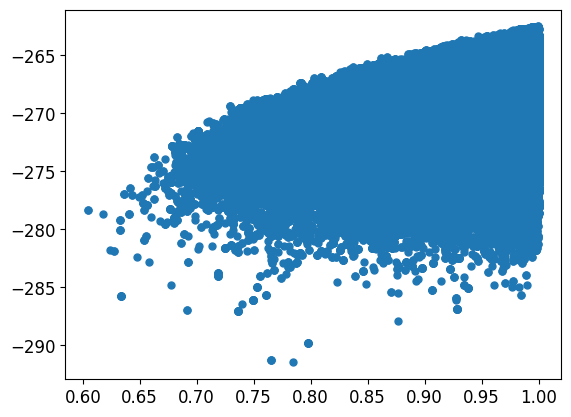

In [22]:
pl.scatter(samples.reshape(-1, 12)[:,-1], log_prob.reshape(-1))

Inner planet:

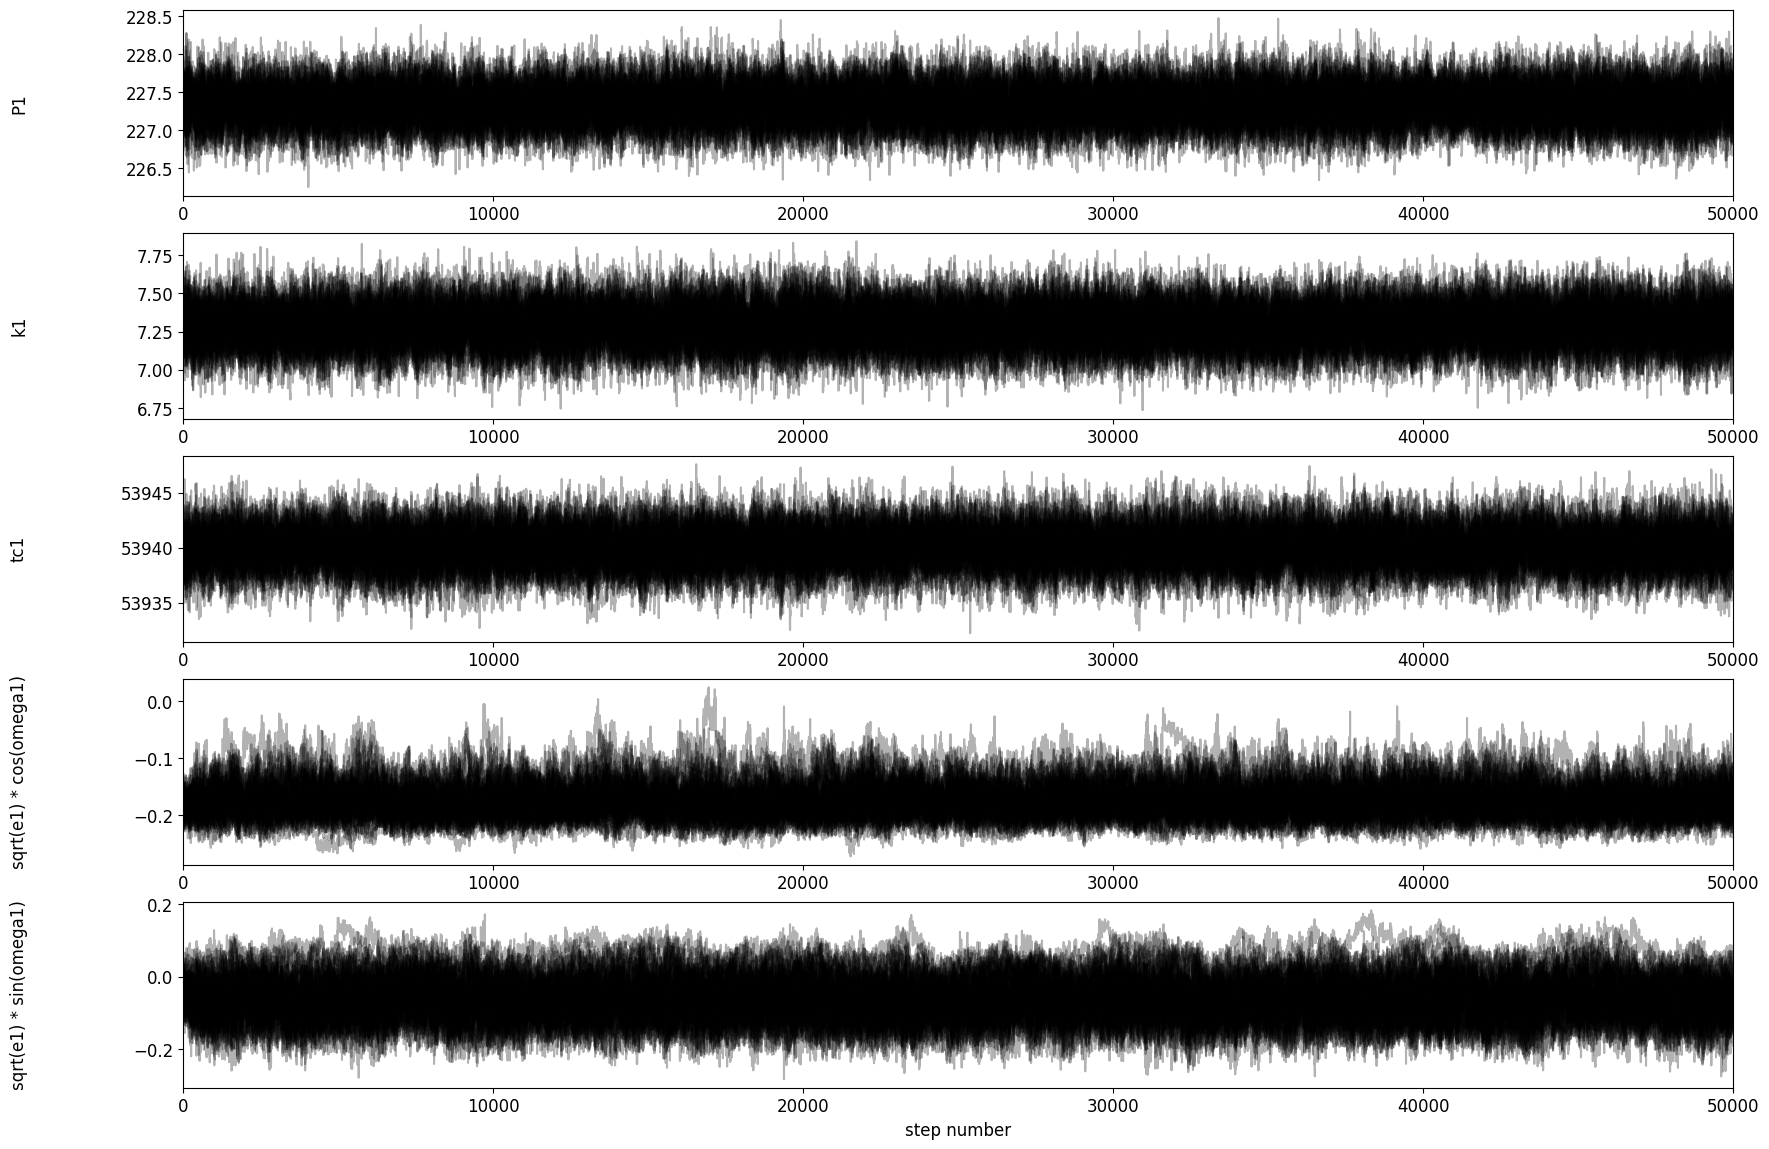

In [23]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels1 = ['P1', 'k1', 'tc1', 'sqrt(e1) * cos(omega1)', 'sqrt(e1) * sin(omega1)']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

Outer planet:

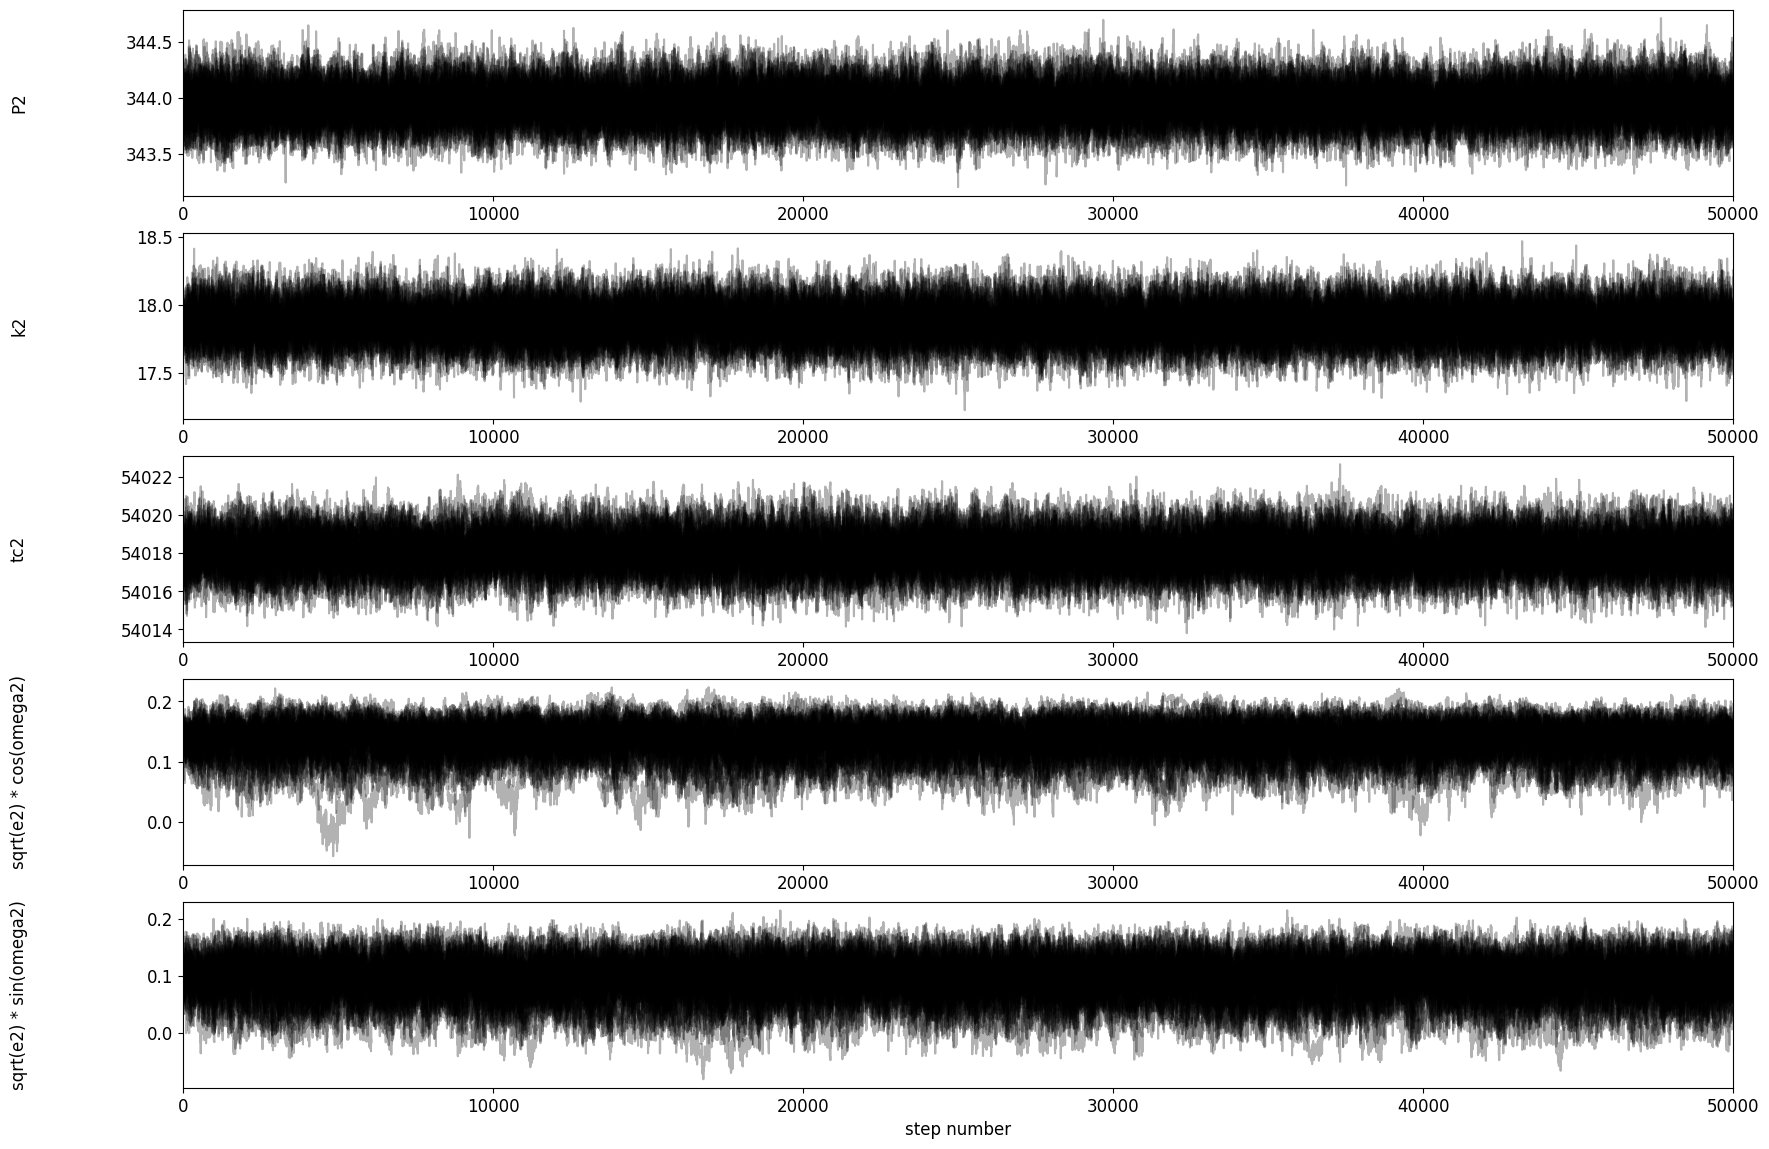

In [24]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels2 = ['P2', 'k2', 'tc2', 'sqrt(e2) * cos(omega2)', 'sqrt(e2) * sin(omega2)']

for i in range(5, 10):
    ax = axes[i - 5]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels2[i - 5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

For `rv_offset` and `sin_i`:

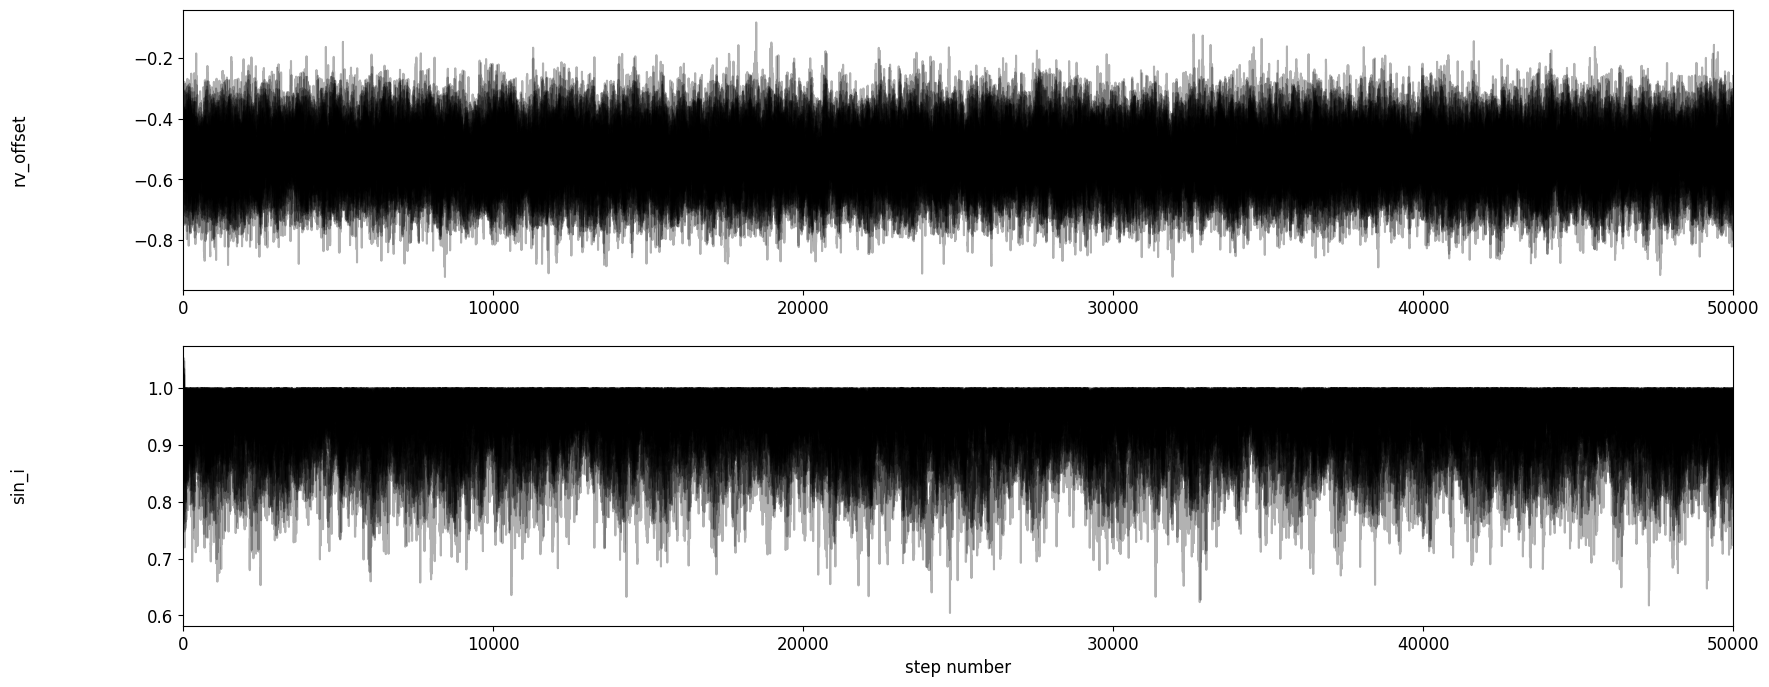

In [25]:
_, axes = pl.subplots(2, figsize=(20, 8))
labels3 = ['rv_offset', 'sin_i']
for i in range(10, 12):
    ax=axes[i - 10]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels3[i - 10])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");
        
# pl.figure(figsize = (20, 4))
# pl.plot(samples[:, :, 10], 'k', alpha = 0.3)
# pl.xlim(0, len(samples))
# pl.xlabel('step number'), pl.ylabel('rv_offset')

Flatten and make corner plots

In [26]:
samples = samples[200:]  # discard the first 200 samples ("burn-in" time)
log_prob = log_prob[200:]  # discord the same log probs
flat_samples = samples.reshape(-1, samples.shape[-1])  # reshape the chain to flatten it out
# flat_samples.shape

In [27]:
start = time.time() # time the plotting since the rendering and display takes a long time

In [28]:
msini = semiamp_to_mass(17.872/AUDAY_MS, star_mass=STAR_MASS, period=343.361, eccentricity=0.027, inclination=np.pi/2)
msini/0.962

0.5869288051335644

In [29]:
# # plot this only if needed
# labels = np.concatenate((labels1, labels2, labels3))
# cornerplot = corner.corner(
#     flat_samples, labels = labels, show_titles=True, truths = best, quantiles=[0.05, 0.5, 0.95], verbose=True)

In [30]:
end = time.time()
print(f'time to plot: {end - start}')  # takes about 5 minutes or so to plot which is a bit annoying

time to plot: 0.027562379837036133


Finding best fit of MCMC by log probability:

In [31]:
best_fit_loc = np.argmax(log_prob)
best_params_mcmc = flat_samples[best_fit_loc]

In [32]:
best_params_mcmc

array([ 2.27350792e+02,  7.28058940e+00,  5.39392399e+04, -1.88087463e-01,
       -3.65245881e-02,  3.43958446e+02,  1.78366610e+01,  5.40187681e+04,
        1.42661524e-01,  7.72297819e-02, -5.42394086e-01,  9.95148157e-01])

In [33]:
log_probability(best), log_probability(best_params_mcmc)

(-262.48720915154973, -262.9604469591763)

Plot against best-fit from earlier and find residuals:

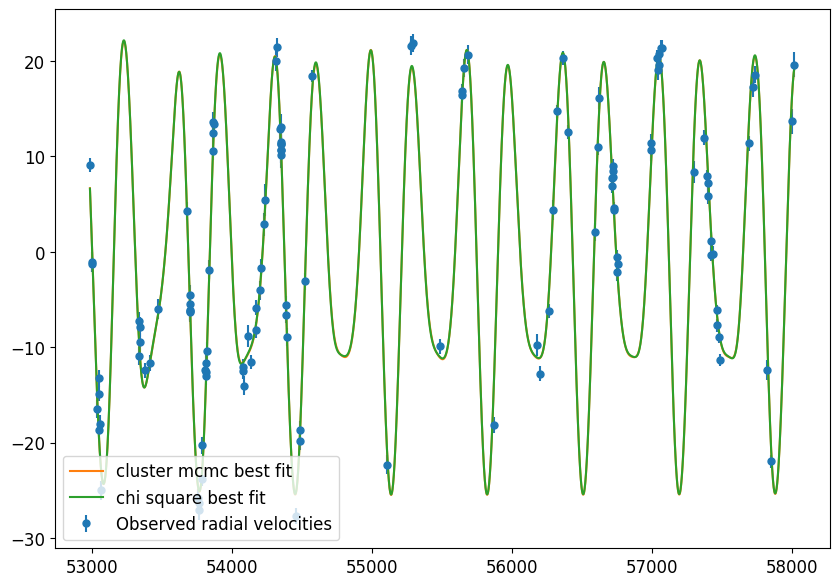

In [34]:
# times = np.linspace(like.x[0], like.x[-1], 1000)

pl.figure(figsize = (10, 7))
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed radial velocities')
pl.plot(times, get_rvs(best_params_mcmc, times = times, integrator = 'ias15', time_base = obs_time_base), label = 'cluster mcmc best fit')  # best fit params mcmc
pl.plot(times, get_rvs(best, times = times, integrator = 'ias15', time_base = obs_time_base), label = 'chi square best fit')  # best fit params with chi square
# pl.plot(times, get_rvs(fit_params.x, inclination= np.pi/2, times = times, integrator = 'ias15'), label = 'no chi square')  # earlier fit only with least squares
pl.legend(loc = 'lower left')

In [35]:
resids1 = get_nbody_resids(best_params_mcmc, 'ias15')  # chi squared from mcmc best fit params
resids2 = get_nbody_resids(best, 'ias15')  # chi squared from starting guess (using least squares and chi square optimization)
# resids3 = get_nbody_resids(fit_params.x, 'ias15')  # chi squared from least squares without chi square optimization

[(resids @ resids)/2 for resids in [resids1, resids2]]  # looks like the chi square fit (double otpimized one) is still best

[275.75227353701865, 275.27903572939204]

2D histograms:

In [36]:
e1 = samples[:, :, 3] ** 2 + samples[:, :, 4] ** 2  # computing eccentricity
e2 = samples[:, :, 8] ** 2 + samples[:, :, 9] ** 2  # computing eccentricity
p1 = samples[:, :, 0]
k1 = samples[:, :, 1]
p2 = samples[:, :, 5]
k2 = samples[:, :, 6]

sin_i = samples[:, :, -1] # sin_i
rv_offset = samples[:, :, -2]  # rv_offset

 # print(k1.shape, p1.shape, e1.shape)

m1sini = semiamp_to_mass(k1/(AUDAY_MS), STAR_MASS, p1, e1, inclination = np.arcsin(sin_i))
m2sini = semiamp_to_mass(k2/(AUDAY_MS), STAR_MASS, p2, e2, inclination = np.arcsin(sin_i))
# print(m1.shape, e1.shape, m2.shape, e1.shape)

Since `m1sini`, `m2sini` are actually $m_1\sin(i)$ and $m_2\sin(i)$, divide them by $\sin(i)$ to get the mass distribution:

In [37]:
m1_dist, m2_dist = m1sini/sin_i, m2sini/sin_i

(array([2.700000e+01, 1.550000e+02, 1.119000e+03, 4.770000e+03,
        1.653800e+04, 5.087400e+04, 1.361290e+05, 3.170030e+05,
        6.734620e+05, 1.289923e+06]),
 array([0.60440056, 0.64396048, 0.68352041, 0.72308033, 0.76264025,
        0.80220018, 0.8417601 , 0.88132003, 0.92087995, 0.96043987,
        0.9999998 ]),
 <BarContainer object of 10 artists>)

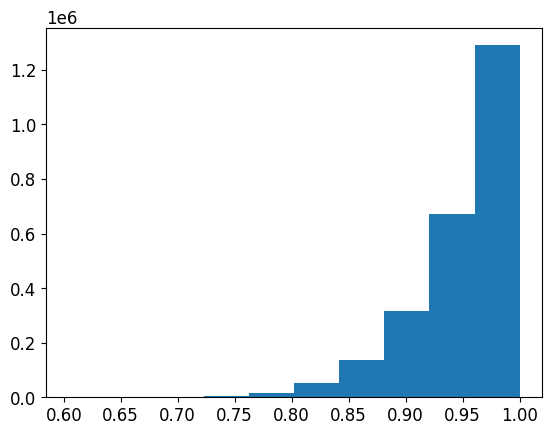

In [38]:
pl.hist(sin_i.reshape(-1))

e1 v e2 with best-fit line:

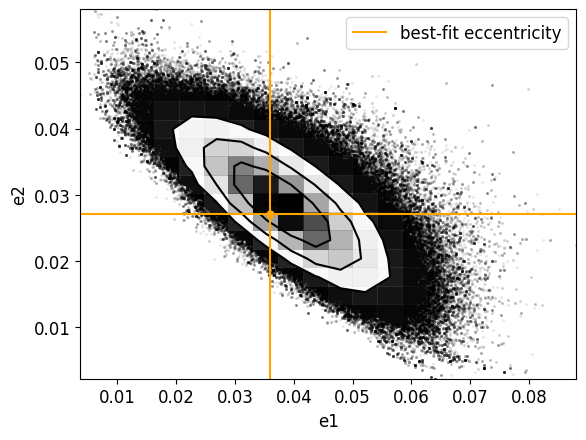

In [39]:
corner.hist2d(e1.reshape(-1), e2.reshape(-1))  # 2d histogram of eccentricities
# pl.scatter(e_inner, e_outer, label = 'ecc track w damping')  # TODO: find best-fit track of eccentricities
# plot true e value on top
true_es = [best[3] ** 2 + best[4] ** 2, best[8] ** 2 + best[9] ** 2]
pl.scatter(true_es[0], true_es[1], color = 'orange')
pl.axvline(true_es[0], color = 'orange'), pl.axhline(true_es[1], color = 'orange', label = 'best-fit eccentricity')
pl.xlabel('e1'), pl.ylabel('e2')
pl.legend(loc = 'upper right')

m1_dist v m2_dist histogram (posterior distributions):

In [40]:
corner.quantile(m1_dist.reshape(-1), [0.05, 0.95]), corner.quantile(m2_dist.reshape(-1), [0.05, 0.95]), #true_ms

(array([0.20044933, 0.27095139]), array([0.56735344, 0.76284764]))

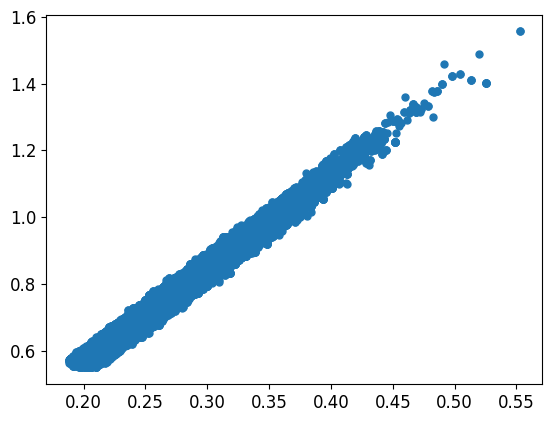

In [41]:
pl.scatter(m1_dist.reshape(-1), m2_dist.reshape(-1))

not sure what everything from here down to the new stuff is all about...

In [42]:
e1 = samples[:, :, 3] ** 2 + samples[:, :, 4] ** 2  # computing eccentricity
e2 = samples[:, :, 8] ** 2 + samples[:, :, 9] ** 2  # computing eccentricity
p1 = samples[:, :, 0]
k1 = samples[:, :, 1]
p2 = samples[:, :, 5]
k2 = samples[:, :, 6]


In [43]:
sin_i.reshape(-1)[22]

0.9678138136206978

In [44]:
testsamp = flat_samples[22]
testsamp

array([ 2.27456218e+02,  7.37584379e+00,  5.39397570e+04, -1.71727075e-01,
       -5.90348475e-02,  3.43793160e+02,  1.78527695e+01,  5.40190936e+04,
        1.49967277e-01,  5.45952397e-02, -5.36166864e-01,  9.67813814e-01])

In [45]:
teste1 = testsamp[3] ** 2 + testsamp[4] ** 2
teste2 = testsamp[8] ** 2 + testsamp[9] ** 2
testp1, testk1 = testsamp[0], testsamp[1]
testp2, testk2 = testsamp[5], testsamp[6]
testsini = testsamp[-2]

testm1sini = semiamp_to_mass(testk1/AUDAY_MS, STAR_MASS, testp1, teste1, np.arcsin(testsini))
testm2sini = semiamp_to_mass(testk2/AUDAY_MS, STAR_MASS, testp2, teste2, np.arcsin(testsini))

teste1, teste2, testp1, testp2, testk1, testk2, testsini, testm1sini, testm2sini

(0.03297530148346272, 0.025470824489590614, 227.45621798998062, 343.79315982810056, 7.375843790144884, 17.852769463559
245, -0.5361668639197504, -0.3787943334219576, -1.0524282354558545)

In [46]:
corner.quantile(e1.reshape(-1), [0.05, 0.95]), corner.quantile(e2.reshape(-1), [0.05, 0.95])

(array([0.02395024, 0.05349521]), array([0.01822109, 0.03944982]))

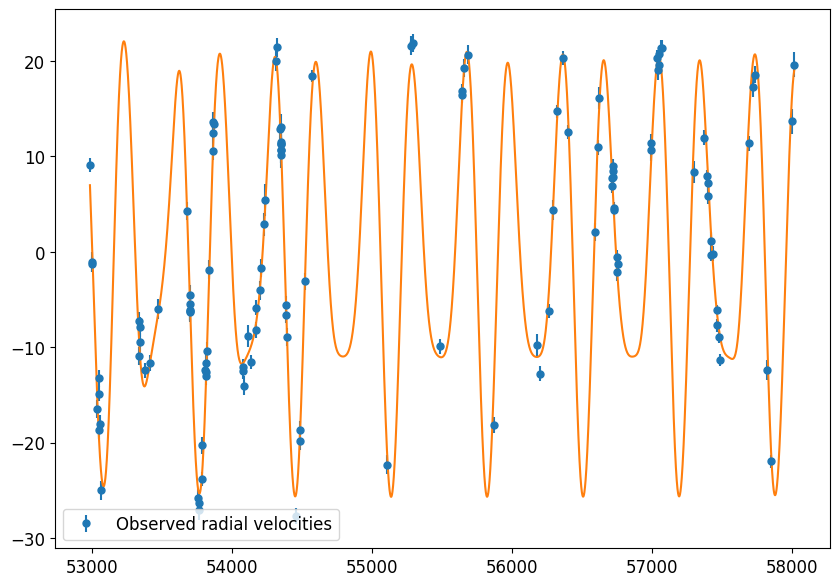

In [47]:
pl.figure(figsize = (10, 7))
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed radial velocities')
pl.plot(times, get_rvs(flat_samples[22], times = times, integrator = 'ias15', time_base = obs_time_base))
pl.legend(loc = 'lower left')

## New stuff below (from March 2023):

Again plot the $\sin(i)$ value against the negative log likelihood:

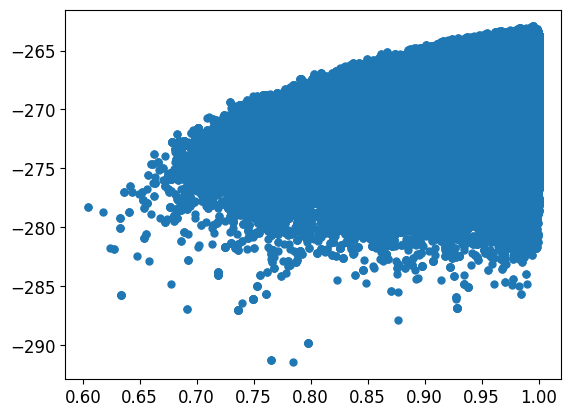

In [51]:
pl.scatter(samples.reshape(-1, 12)[:,-1], log_prob.reshape(-1))  # sin(i) doesn't seem to affect it so much anymore when I add in jitter... why????

In [52]:
# m1, m2 are m1sini, m2sini so need to use m1_dist, m2_dist
total_mass = m1_dist.reshape(-1) + m2_dist.reshape(-1)
sin_is = sin_i.reshape(-1)

(array([2.700000e+01, 1.550000e+02, 1.119000e+03, 4.770000e+03,
        1.653800e+04, 5.087400e+04, 1.361290e+05, 3.170030e+05,
        6.734620e+05, 1.289923e+06]),
 array([0.60440056, 0.64396048, 0.68352041, 0.72308033, 0.76264025,
        0.80220018, 0.8417601 , 0.88132003, 0.92087995, 0.96043987,
        0.9999998 ]),
 <BarContainer object of 10 artists>)

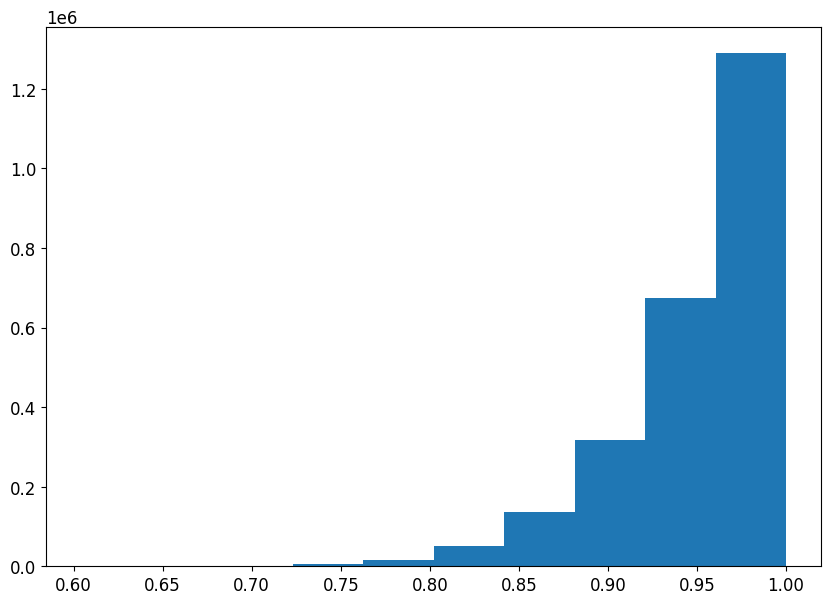

In [53]:
pl.figure(figsize = (10, 7))
pl.hist(sin_is)
# pl.hist(total_mass)

In [54]:
np.quantile(sin_is, [0.05, 0.5, 0.95]), np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]), np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95])

(array([0.86085184, 0.96231688, 0.99705028]),
 array([0.02395024, 0.03846728, 0.05349521]),
 array([0.01822109, 0.02874602, 0.03944982]))

In [55]:
true_ms = [semiamp_to_mass(best[1]/AUDAY_MS, STAR_MASS, best[0], true_es[0], inclination = np.pi/2), semiamp_to_mass(best[6]/AUDAY_MS, STAR_MASS, best[5], true_es[1], inclination = np.pi/2)]


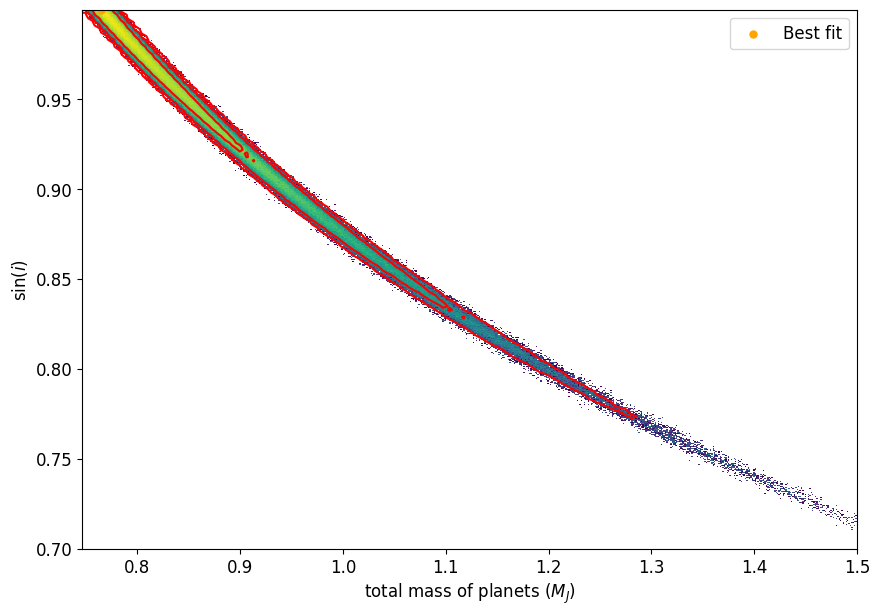

In [63]:
import matplotlib as mpl

pl.figure(figsize = (10, 7))
# contour lines
corner.hist2d(total_mass, sin_is, s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'Contours')
# histogram with log norm
pl.hist2d(total_mass, sin_is, norm=mpl.colors.LogNorm(), bins=1000)  # log norm
pl.scatter(true_ms[0] + true_ms[1], 1, color = 'orange', label ='Best fit')
pl.xlabel(r'total mass of planets ($M_J$)'), pl.ylabel(r'$\sin(i)$')
# x limit
pl.xlim(right=1.5), pl.ylim(bottom=0.7)
pl.legend()
pl.savefig('sin_i_mtot_dist.png')#, fmt='png')

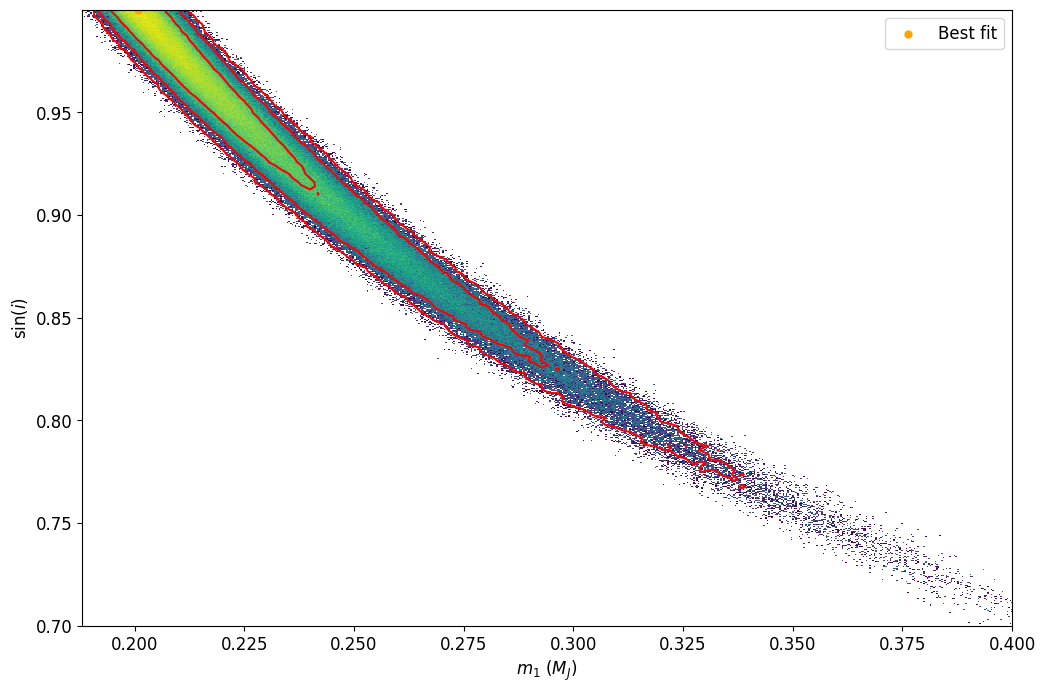

In [66]:
import matplotlib as mpl
pl.figure(figsize = (12, 8))
# contour lines
corner.hist2d(m1_dist.reshape(-1), sin_is.reshape(-1), s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'Contours')
# histogram with log norm
pl.hist2d(m1_dist.reshape(-1), sin_is.reshape(-1), norm=mpl.colors.LogNorm(), bins=1000)  # log norm
pl.scatter(true_ms[0], 1, color = 'orange', label ='Best fit')
pl.xlabel(r'$m_1$ ($M_J$)'), pl.ylabel(r'$\sin(i)$')
# x limit
pl.xlim(right=0.4), 
pl.ylim(bottom=0.7)
pl.legend()
pl.savefig('sin_i_m1_dist.png')#, fmt='png')

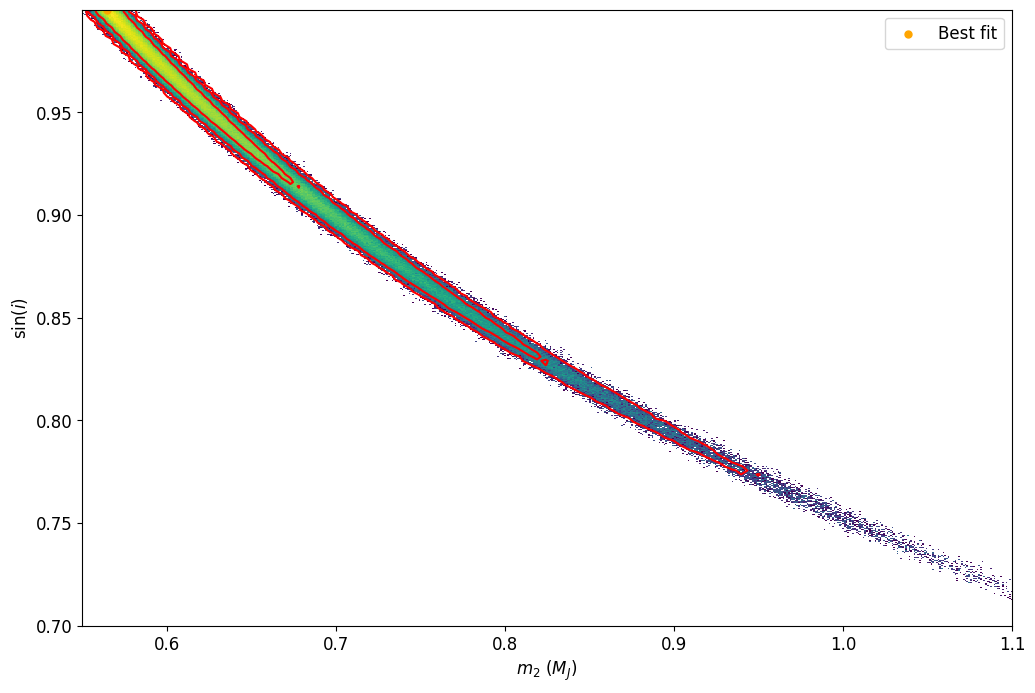

In [69]:
import matplotlib as mpl
pl.figure(figsize = (12, 8))
# contour lines
corner.hist2d(m2_dist.reshape(-1), sin_is.reshape(-1), s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'Contours')
# histogram with log norm
pl.hist2d(m2_dist.reshape(-1), sin_is.reshape(-1), norm=mpl.colors.LogNorm(), bins=1000)  # log norm
pl.scatter(true_ms[1], 1, color = 'orange', label ='Best fit')
pl.xlabel(r'$m_2$ ($M_J$)'), pl.ylabel(r'$\sin(i)$')
# x limit
pl.xlim(right=1.1), 
pl.ylim(bottom=0.7)
pl.legend()
pl.savefig('sin_i_m2_dist.png')#, fmt='png')

(Text(0.5, 0, 'total mass of planets ($M_J$)'), Text(0, 0.5, '$\\sin(i)$'))

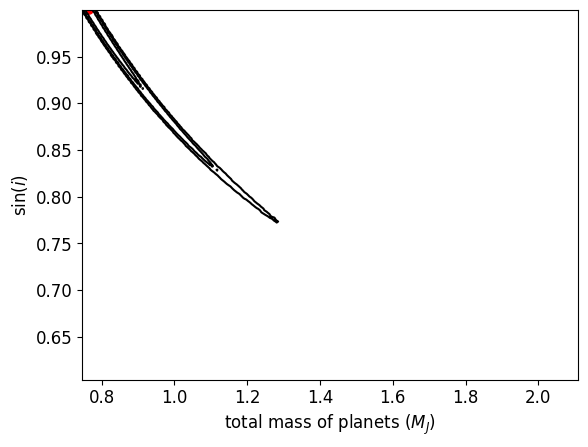

In [70]:
corner.hist2d(total_mass, sin_is, s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99])
pl.scatter(true_ms[0] + true_ms[1], 1, color = 'red', label ='best fit')
pl.xlabel(r'total mass of planets ($M_J$)'), pl.ylabel(r'$\sin(i)$')

this one might be wrong now...

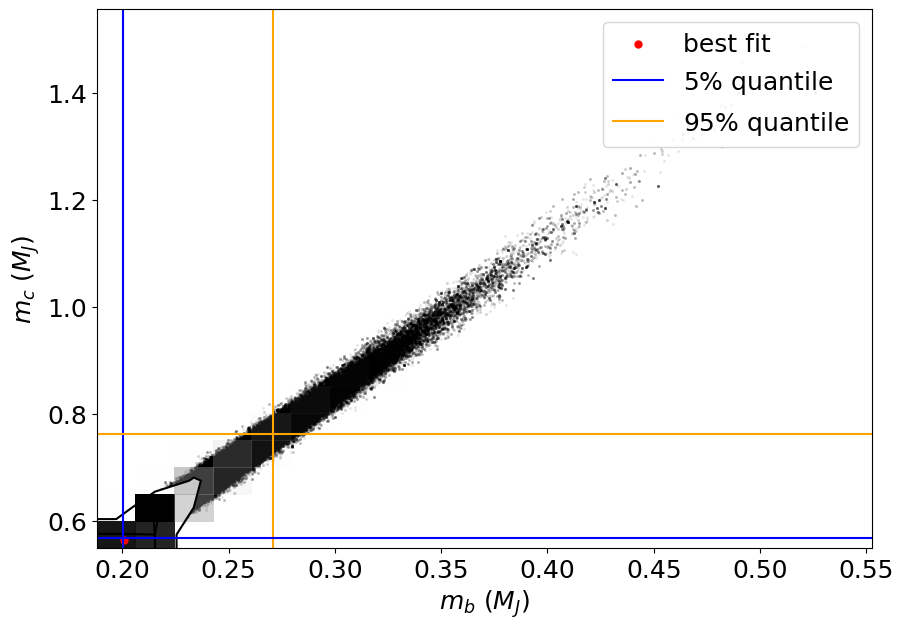

In [71]:
m1_pctls = corner.quantile(m1_dist.reshape(-1), [0.05, 0.95])
m2_pctls = corner.quantile(m2_dist.reshape(-1), [0.05, 0.95])

pl.figure(figsize = (10, 7))
pl.rc('font', size=18)
corner.hist2d(m1_dist.reshape(-1), m2_dist.reshape(-1), plot_density=True, plot_contours=True)
# corner.hist2d(m1.reshape(-1), m2.reshape(-1))  # 2d histogram
# plot true mass values making sure to convert semiamplitude to mass from aus/day back to m/s
pl.scatter(true_ms[0], true_ms[1], color = 'red', label ='best fit')
# pl.axvline(true_ms[0], color = 'orange'), pl.axhline(true_ms[1], color = 'orange', label = 'best fit')
pl.axvline(m1_pctls[0], color='blue', label =r'$5\%$ quantile')
pl.axvline(m1_pctls[1], color='orange', label=r'$95\%$ quantile')
pl.axhline(m2_pctls[0], color='blue'), pl.axhline(m2_pctls[1], color='orange')
# pl.annotate('best fit', xy=(true_ms), xycoords='data', textcoords='axes fraction', xytext=(0.7, 0.2), 
#             arrowprops=dict(facecolor='red', shrink=0.001), color='red')
#     (fr'$P_c \approx {int(np.round(outer.P, p_roundto))}$ days, $m_c \approx {np.round(outer.m, m_roundto)} M_J$,  $e_c \approx {np.round(outer.e, e_roundto)}$', 
#             xy=(outer.x, outer.y), xycoords='data', textcoords='axes fraction', xytext = (0.3, 0.05), 
#             arrowprops=dict(facecolor='cyan', shrink=0.01), color='cyan')
pl.xlabel(r'$m_{b}$ $\left(M_J\right)$'), pl.ylabel(r'$m_{c}$ $\left(M_J\right)$')
# pl.ylim(bottom=0.5)
pl.legend(loc = 'upper right')
# pl.savefig('sin_i_mass_dist.png', fmt='png')
pl.show()

m1sini v e1, m2sini v e2 histograms:

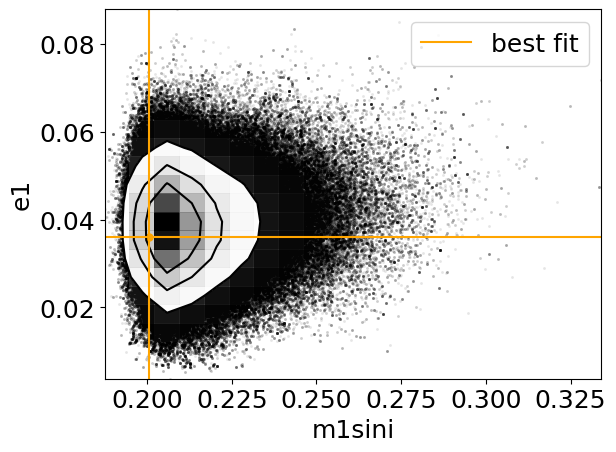

In [72]:
corner.hist2d(m1sini.reshape(-1), e1.reshape(-1))  # 2d histogram
pl.scatter(true_ms[0], true_es[0], color = 'orange')  # best fit dot and line
# pl.scatter(true_me1[0], true_me1[1], color = 'orange')
pl.axvline(true_ms[0], color = 'orange'), pl.axhline(true_es[0], color = 'orange', label = 'best fit')
pl.xlabel('m1sini'), pl.ylabel('e1')
pl.legend(loc = 'upper right')

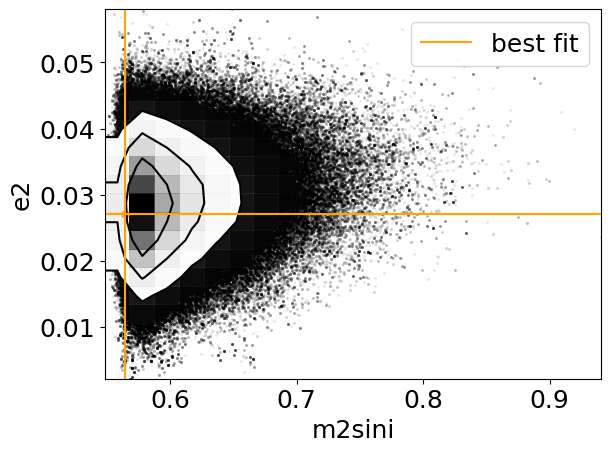

In [73]:
corner.hist2d(m2sini.reshape(-1), e2.reshape(-1))  # 2d histogram
pl.scatter(true_ms[1], true_es[1], color = 'orange')  # best fit dot and line
# pl.scatter(true_me1[0], true_me1[1], color = 'orange')
pl.axvline(true_ms[1], color = 'orange'), pl.axhline(true_es[1], color = 'orange', label = 'best fit')
pl.xlabel('m2sini'), pl.ylabel('e2')
pl.legend(loc = 'upper right')

## end of march 2023 changes (ignore everything below this part):

Plotting changes in mean longitude angle (resonance):

In [ ]:
def get_mean_longitude_angles(sim, angle_times):
    """
    return array of mean longitude angles for inner, outer planet given a simulation and array of times
    param sim: rebound simulation
    param angle_times: array of times to integrate over
    
    return: tuple of (angle1, angle2, e1, e2), four arrays with the mean longitude angles and eccentricities for the planets, each of length len(angle_times)
    """
    e1, e2 = np.zeros(len(angle_times)), np.zeros(len(angle_times))
    angle1, angle2 = np.zeros(len(angle_times)), np.zeros(len(angle_times))  # init empty arrays
    
    for i, t in enumerate(angle_times):  # run the simulation over array of times
        sim.integrate(t)
        e1[i] = sim.particles[1].e  # e1, e2
        e2[i] = sim.particles[2].e
        resonant_angle = 3 * sim.particles[2].l - 2 * sim.particles[1].l
        angle1[i] = resonant_angle - sim.particles[1].pomega  # calculate mean longitude angles of both planets
        angle2[i] = resonant_angle - sim.particles[2].pomega
    
    return angle1, angle2, e1, e2  # return tuple

In [ ]:
sample_num = 25000  # change this to grab a random sample for the plotting
n_angle_times = 5000  # number of samples (times) to simulate through for each mean longitude angle calculation

For original simulation:

In [ ]:
sim1 = get_sim_from_params(flat_samples[sample_num], 'ias15', post.model.time_base)  # start sim
angle_times = np.linspace(0, 500 * sim1.particles[1].P, n_angle_times) + sim1.t   # angle times

In [ ]:
angle1, angle2, ml_e1, ml_e2 = np.mod(get_mean_longitude_angles(sim1, angle_times), 2 * np.pi)  # calculate mean longitude angles (mod 2pi)

In [ ]:
pl.plot(np.unwrap(angle2))
pl.plot(np.unwrap(angle1))

In [ ]:
unwrapped_angle1 = np.unwrap(angle1)
unwrapped_angle2 = np.unwrap(angle2)

# pl.plot(angle_times, unwrapped_angle1, 'o')
pl.figure(figsize = (8, 6))
pl.plot(angle_times, np.mod(angle1 + np.pi, 2 * np.pi), 'o', label = 'inner planet')
# pl.plot(np.concatenate([angle_times[neg_inds], angle_times[pos_inds]]), np.concatenate([neg_angles, pos_angles]), 'o', label = 'inner planet')
# pl.plot(angle_times, angle2, 'o', label = 'outer planet')
pl.xlabel('time after time_base (days)'), pl.ylabel('mean longitude angle (radians)')
pl.legend()


Eccentricity of best-fit solution over time:

In [ ]:
pl.figure(figsize = (20, 7))
pl.plot(angle_times, ml_e1, label = 'inner planet')
pl.plot(angle_times, ml_e2, label = 'outer planet')
pl.xlabel('Time'), pl.ylabel('Eccentricity')
pl.legend(loc = 'upper right')

Rotate system to see if it changes anything

In [ ]:
r = np.matrix([[1, 0, 0],
                [0, 0, 1],
                [0, 1, 0]])  # np.pi/2 rotation matrix

In [ ]:
sim2 = get_sim_from_params(flat_samples[sample_num], 'ias15', post.model.time_base)  # start new sim for sim2 (rotated)
angle_times = np.linspace(0, 500 * sim2.particles[1].P, n_angle_times) + sim2.t   # angle times for sim2


# implement rotation for particle 0
sim2.particles[0].x, sim2.particles[0].y, sim2.particles[0].z = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[0].xyz)))
sim2.particles[0].vx, sim2.particles[0].vy, sim2.particles[0].vz = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[0].vxyz)))

# implement rotation for particle 1
sim2.particles[1].x, sim2.particles[1].y, sim2.particles[1].z = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[1].xyz)))
sim2.particles[1].vx, sim2.particles[1].vy, sim2.particles[1].vz = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[1].vxyz)))

# implement rotation for particle 2
sim2.particles[2].x, sim2.particles[2].y, sim2.particles[2].z = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[2].xyz)))
sim2.particles[2].vx, sim2.particles[2].vy, sim2.particles[2].vz = tuple(np.ndarray.flatten(np.array(r @ sim2.particles[2].vxyz)))

# align simulation using celmech so that z-axis is aligned with the direction of angular momentum:
align_simulation(sim2)

Plot again for the rotated system:

In [ ]:
angle1_rot, angle2_rot, e1_rot, e2_rot = np.mod(get_mean_longitude_angles(sim2, angle_times), 2 * np.pi)  # calculate mean longitude angles (mod 2pi)

In [ ]:
unwrapped_angle1_rot = np.unwrap(angle1_rot)
unwrapped_angle2_rot = np.unwrap(angle2_rot)

# pl.plot(angle_times, unwrapped_angle1_rot, 'o')
pl.figure(figsize = (8, 6))
pl.plot(angle_times, angle1_rot, 'o', label = 'inner planet')
pl.plot(angle_times, angle2_rot, 'o', label = 'outer planet')
pl.xlabel('time after time_base (days)'), pl.ylabel('mean longitude angle (radians)')
pl.legend()

In [ ]:
neg_inds_angles = np.array([[i, angle - 2 * np.pi] for i, angle in enumerate(angle1) if angle > np.pi])  
# splits into "positive" angles between 0 and pi, and "negative" angles between pi and 2pi
neg_angles = neg_inds_angles[:, 1]
pos_angles = np.array([angle for i, angle in enumerate(angle1) if i not in neg_inds_angles[:, 0].astype(int)])
# concatenate the two arrays
angle1 = np.concatenate([neg_angles, pos_angles])

lib_amp = (np.max(angle1) - np.min(angle1))/2
lib_amp

Eccentricity of best-fit solution over time for rotated case:

In [ ]:
pl.figure(figsize = (20, 7))
pl.plot(angle_times, e1_rot, label = 'inner planet')
pl.plot(angle_times, e2_rot, label = 'outer planet')
pl.xlabel('Time'), pl.ylabel('Eccentricity')
pl.legend(loc = 'upper right')

Plots are the same as before, which is expected.

Take 1000 posterior samples and plot libration amplitude cdf:

In [ ]:
n_samples = 1000

np.random.seed(1234)  # set the seed to something random
posterior_params = np.random.default_rng().choice(flat_samples, n_samples, replace=False, axis = 0)  # sample randomly without replacement, taking 1000 samples from flat_samples

Calculate libration amplitudes of inner, outer planets for each of the samples (maximum amplitude of the librations within the times in `angle_times`):

In [ ]:
n_angle_times = 500  # try this by default
lib_amp1, lib_amp2, e1s, e2s = np.zeros(n_samples), np.zeros(n_samples), np.zeros(n_samples), np.zeros(n_samples)  # init libration amplitude arrays

for i, pars in tqdm(enumerate(posterior_params)):  # time this since it takes a while
    # create simulation and angle_times array for a given set of parameters
    angle_sim = get_sim_from_params(pars, 'ias15', post.model.time_base)
    angle_times = np.linspace(0, 500 * angle_sim.particles[1].P, n_angle_times) + angle_sim.t
    
    # find mean longitude angle arrays by simulating through it (don't care about e1 or e2)
    angle1, angle2, ml_e1, ml_e2 = np.mod(get_mean_longitude_angles(angle_sim, angle_times), 2 * np.pi) # modulo 2pi again
    
    # for lib_amp1 need to make the angles between pi/2 and 2pi negative, so that the min max comparison works properly
    # "wraps around" all angles between pi/2 and 2pi, and gets their indices and values
    neg_inds_angles = np.array([[i, angle - 2 * np.pi] for i, angle in enumerate(angle1) if angle > np.pi])  
    # splits into "positive" angles between 0 and pi, and "negative" angles between pi and 2pi
    neg_angles = neg_inds_angles[:, 1]
    pos_angles = np.array([angle for i, angle in enumerate(angle1) if i not in neg_inds_angles[:, 0].astype(int)])
    # concatenate the two arrays
    angle1 = np.concatenate([neg_angles, pos_angles])
    
    # take max - min angle to approximate the maximum libration amplitude for that set of parameters
    lib_amp1[i] = (np.max(angle1) - np.min(angle1))/2
    lib_amp2[i] = (np.max(angle2) - np.min(angle2))/2
    e1s[i] = ml_e1[0]
    e2s[i] = ml_e2[0]

    # takes 4-5 minutes to run

Plot histogram of libration amplitudes for inner and outer planets:

In [ ]:
nbins = 50

pl.figure(figsize = (8, 6))
count1, bins1, _ = pl.hist(lib_amp1, bins = nbins, label = 'inner planet')
count2, bins2, _ = pl.hist(lib_amp2, bins = nbins, label = 'outer planet')
pl.xlabel('Libration amplitude (radians)'), pl.ylabel('count (unnormalized)')  # TODO: normalize this
pl.legend()

In [ ]:
small_amp1 = lib_amp1[lib_amp1 < np.pi/2]
small_amp2 = lib_amp2[lib_amp2 < np.pi/2]

small_amp_e1s = e1s[lib_amp1 < np.pi/2]  # split in lib_amp1
small_amp_e2s = e2s[lib_amp1 < np.pi/2]

In [ ]:
# corner.hist2d(e1.reshape(-1), e2.reshape(-1))
corner.hist2d(small_amp_e1s, small_amp_e2s)

Plot CDF:

In [ ]:
pl.figure(figsize = (8, 6))
pl.plot(bins1[1:], np.cumsum(count1)/n_samples, label = 'inner planet')  # normalize to get a CDF
pl.plot(bins2[1:], np.cumsum(count2)/n_samples, label = 'outer planet')
pl.xlabel('Libration amplitude (radians)'), pl.ylabel('Cumulative fraction')
pl.legend()

Run n-body simulations with the posterior samples to see if they are stable:

In [ ]:
pl.figure(figsize = (10, 7))
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'ro', label = 'Observed radial velocities')
for pars in posterior_params:
    pl.plot(times, get_rvs(pars, times = times, integrator = 'ias15'))
pl.plot(times, get_rvs(best, times = times, integrator = 'ias15'), label = 'chi square')
pl.legend(loc = 'lower left')

mostly all the same

### Mass upper bounds

Assume planets are in resonance and coplanar, which locks them to being in one particular track in the $\frac{e_1}{e_2}$ plane, depending on the $\frac{\tau_a}{\tau_e}$ ratio. Calculating the eccentricity track using their minimum masses and period ratio:

In [44]:
ecc_sim = get_sim_from_params(fit_params_chi2.x, integrator = 'whfast', time_base = 0)
planet_masses = np.array([ecc_sim.particles[1].m, ecc_sim.particles[2].m])/ecc_sim.particles[0].m
best_fit_es = np.array([ecc_sim.particles[1].e, ecc_sim.particles[2].e])

In [45]:
nsims = 100  # try 100 could also do 50 for fewer
Ks = np.logspace(0, 5, nsims)

Eccentricity tracks:

In [46]:
def get_eccentricity_tracks(masses, Ks, period_ratio, filename, t_end=3e4, tau_e_factor=3):
    """
    Gets planet eccentricity tracks for a simulation with two planets. Assumes that planets are coplanar
    and are in MMR with ratio period_ratio

    param masses: array of 2 planet masses masses in units of jupiter masses/parent star masses
    param Ks: factor of tau_a * tau_e to multiply by (testing different ratios of tau_a to tau_e):
    param period_ratio: resonant period ratio of the two planets (outer period/inner period)
    """
    e1_track, e2_track = np.zeros(len(Ks)), np.zeros(len(Ks))
    
    for ind, K in tqdm(enumerate(Ks)):
        sim = get_simple_sim(masses)

        inner = sim.particles[1]  # inner and outer planets in our simulation
        outer = sim.particles[2]

        rebx = reboundx.Extras(sim)  # eccentricity and migration forces
        rebx.add_force(rebx.load_force('modify_orbits_forces'))
        rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

        # outer.params['tau_a'] = -10 * t_end  
        inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant

        tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

        # set the semi-major axis damping for inner and outer planets
        outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m, period_ratio = period_ratio)  # 3/2 period ratio
        
        sim.integrate(t_end) # integrate to t_end to find the equilibrium eccentricities
        
        sim.save(filename)  # collect the snapshots in a simulation archive

        e1_track[ind] = inner.e
        e2_track[ind] = outer.e
        
    return e1_track, e2_track  # arrays of length Ks

#### Multiprocessing:

In [47]:
def get_eccentricity_tracks_multiprocessing(params, period_ratio=3/2, t_end=3e4, tau_e_factor=3):
    """
    Gets planet eccentricity tracks for a simulation with two planets. Assumes that planets are coplanar
    and are in MMR with ratio period_ratio

    params: tuple of (masses, Ks, filename):
    masses is an array of planet masses
    K is the tau_a/tau_e ratio for this eccentricity track value (e1, e2)
    filename is the filename to save the simulation archive to
    """
    masses, K, filename = params
    # K = params[1]
    # filename = params[2]

    sim = get_simple_sim(masses)

    inner = sim.particles[1]  # inner and outer planets in our simulation
    outer = sim.particles[2]

    rebx = reboundx.Extras(sim)  # eccentricity and migration forces
    rebx.add_force(rebx.load_force('modify_orbits_forces'))
    rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

    # outer.params['tau_a'] = -10 * t_end
    inner.params['tau_e'], outer.params[
        'tau_e'] = -t_end / tau_e_factor, -t_end / tau_e_factor  # eccentricity damping, these stay constant

    tau_e = 1 / (1 / inner.params['tau_e'] + 1 / outer.params['tau_e'])

    # set the semi-major axis damping for inner and outer planets
    outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m,
                                                                  period_ratio=period_ratio)  # 3/2 period ratio

    sim.integrate(t_end)  # integrate to t_end to find the equilibrium eccentricities
    sim.save(filename)  # save snapshot

    e1_track_val = inner.e
    e2_track_val = outer.e

    return e1_track_val, e2_track_val  # arrays of length Ks

Simulation archive to save this to:

**TODO**: The ecc tracks/max masses were gotten without assuming $sin(i)$ was a free parameter (sin(i) = 1 always), could choose to redo it with `sin_i` as a free parameter if I have time (maybe it could change something)

Only run this if I need to get the eccentricity tracks locally with multiprocessing:

In [48]:
# par_list_ecc = []
# for i, k in enumerate(Ks):
#     filename_ecc = f'ecc_track_archive_local_{i}'  # save each one to a different file
#     par_list_ecc.append((planet_masses, k, filename_ecc))

# # parallelize it
# pool_ecc = InterruptiblePool()
# ecc_track_results = pool_ecc.map(get_eccentricity_tracks_multiprocessing, par_list_ecc)  # get e1, e2 tracks

# e1_track = [tup[0] for tup in ecc_track_results]
# e2_track = [tup[1] for tup in ecc_track_results]

Run this to get ecc track results from the simulationarchive:

In [49]:
ecc_sims_location = 'hd_max_mass'  # folder that the ecc sims are in

e1_track, e2_track = np.zeros(len(Ks)), np.zeros(len(Ks))

for i in range(0, nsims):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    
    e1_track[i] = inner.e  # add the e1/e2 values for that simulation
    e2_track[i] = outer.e

Plot k values for points on the eccentricity track around the best-fit (shown below).

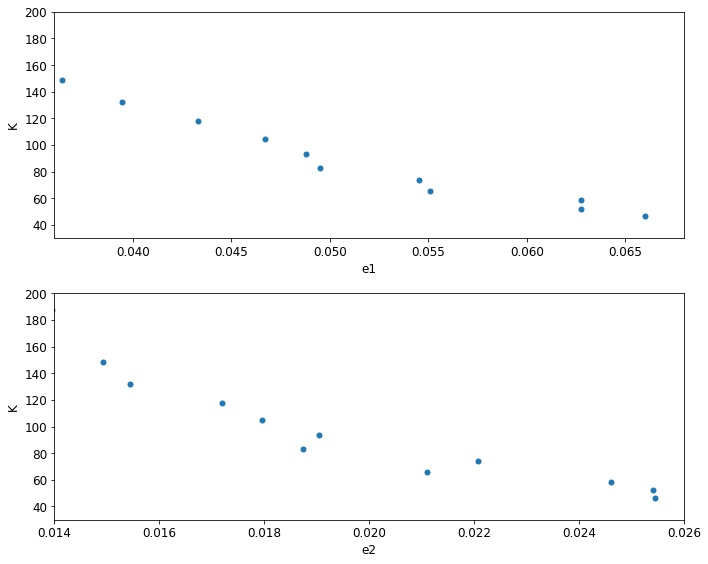

In [50]:
bounds_e1 = (0.036, 0.068)
bounds_e2 = (0.014, 0.026)  # eyeball these

fig, axs = pl.subplots(2, 1, figsize = (10, 8))
f1 = axs[0]
f2 = axs[1]
# e1 vs K
f1.scatter(e1_track, Ks)
# 14 points within the x and ylims (just eyeball what looks close to the distribution)
# eyeball it, make it easier to see
f1.set(xlim = bounds_e1, ylim = (30, 200), xlabel='e1', ylabel='K')
# e2 vs K
f2.scatter(e2_track, Ks)
# eyeball it again to get the same 13 points
f2.set(xlim = bounds_e2, ylim = (30, 200), xlabel = 'e2', ylabel='K')
pl.tight_layout()
pl.show()

Plot the eccentricity track with the best-fit eccentricities, place the 2d histogram of eccentricities on top of it as well, and highlight the points within the best-fit 

In [51]:
pl.figure(figsize = (10, 7))
corner.hist2d(e1.reshape(-1), e2.reshape(-1))  # 2d histogram of eccentricities
true_es = [best[3] ** 2 + best[4] ** 2, best[8] ** 2 + best[9] ** 2] # plot true e value on top

pl.scatter(best_fit_es[0], best_fit_es[1], c = 'orange')  # best fit eccentricity
pl.axvline(best_fit_es[0], color = 'orange'), pl.axhline(best_fit_es[1], color = 'orange', label = 'best-fit eccentricity')  # true value
# plot some values of k within the area around the best-fit with different colours to highlight it:
colours = np.where((bounds_e1[0] < e1_track) & (e1_track < bounds_e1[1]) &
                   (bounds_e2[0] < e2_track) & (e2_track < bounds_e2[1]), 'r', 'C0')
# colors = np.where(df["Animation"]==1,'y','k')
pl.scatter(e1_track, e2_track, c=colours, label = 'eccentricity track')  # track
pl.xlabel(r'$e_1$'), pl.ylabel(r'$e_2$')
pl.title('Eccentricity track')
pl.legend(loc='upper right')
pl.show()

NameError: name 'e1' is not defined

<Figure size 720x504 with 0 Axes>

Calculate some $k$ values for the points within the e1 and e2 joint distribution produced by our MCMC:

In [52]:
K_dist_bounds = Ks[np.where((bounds_e1[0] < e1_track) & (e1_track < bounds_e1[1]) &
                   (bounds_e2[0] < e2_track) & (e2_track < bounds_e2[1]))]
e1_dist = e1_track[np.where((bounds_e1[0] < e1_track) & (e1_track < bounds_e1[1]) &
                   (bounds_e2[0] < e2_track) & (e2_track < bounds_e2[1]))]
e2_dist = e2_track[np.where((bounds_e1[0] < e1_track) & (e1_track < bounds_e1[1]) &
                   (bounds_e2[0] < e2_track) & (e2_track < bounds_e2[1]))]

# K_dist# , e1_dist, e2_dist

# bounds are the ends
K_dist_bounds[0], K_dist_bounds[-1]

(46.4158883361278, 148.4968262254465)

So, we have bounds as $\sim 45 < K < 150$, where $K = \frac{\tau_a}{\tau_e}$ (semi-major axis damping timescale is about 40 to 190 times the length of the eccentricity damping timescale). Note that $e = e_0e^{t/\tau_e}$ and $a = a_0e^{t/\tau_a}$.

Check a bunch of different points along this track ($\frac{\tau_a}{\tau_e}$ ratio) and turn up the mass of the planets until they become unstable to see the maximum masses. Also check the best-fit eccentricities to see when the mass becomes unstable:

Maximum masses:

In [53]:
def get_max_masses(masses, Ks, filename, period_ratio=3/2, t_end=3e5, tau_e_factor=3):
    """
    max masses
    """
    max_m1s, max_m2s = np.zeros(len(Ks)), np.zeros(len(Ks))
    
    for i, K in tqdm(enumerate(Ks)):
        # first do migration/damping to get them in equilibrium
        sim = get_simple_sim(masses)

        inner = sim.particles[1]  # inner and outer planets in our simulation
        outer = sim.particles[2]

        rebx = reboundx.Extras(sim)  # eccentricity and migration forces
        rebx.add_force(rebx.load_force('modify_orbits_forces'))
        rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

        # tau_e
        inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant
        tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

        # set the semi-major axis damping for inner and outer planets

        # tau_a
        outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m, period_ratio = period_ratio)  # 3/2 period ratio

        sim.integrate(t_end) # integrate to t_end to find the equilibrium eccentricities

        # now create a new sim with the equlibirum positions and turn up the masses until there is a close encounter
        new_sim = sim.copy()

        rebx = reboundx.Extras(new_sim)
        rebx.add_operator(rebx.load_operator("modify_mass"))
        
        inner = new_sim.particles[1]
        outer = new_sim.particles[2]

        inner.params['tau_mass'], outer.params['tau_mass'] = 1e5, 1e5
        new_sim.exit_min_distance = 5 * inner.rhill  # 5 times the hill distance as a close encounter

        try:
            new_sim.integrate(1e7)  # doesn't matter what this number is since eventually there will be a close encounter
            # as long as it's large enough so the encounter happens eventually
        except rb.Encounter as error:
            pass

        new_sim.simulationarchive_snapshot(filename)  # archive in simulation
        
        # max masses
        max_m1s[i] = inner.m * STAR_MASS
        max_m2s[i] = outer.m * STAR_MASS
        # since masses are jupiter masses/star masses 
        # to get the max masses in jupiter masses
        
    return max_m1s, max_m2s

### Multiprocessing:

In [54]:
def get_max_masses_multiprocessing(params, period_ratio=3/2, t_end=3e5, tau_e_factor=3):
    """
    params: tuple of params (masses, K, filename)
    masses is an array of planet masses
    K is the tau_a/tau_e ratio for this case
    filename is the file to save the simulationarchive to
    """
    # unpack params:
    masses, K, filename = params # [0]
    # K = params[1]
    # filename = params[2]

    # first do migration/damping to get them in equilibrium
    sim = get_simple_sim(masses)

    inner = sim.particles[1]  # inner and outer planets in our simulation
    outer = sim.particles[2]

    rebx = reboundx.Extras(sim)  # eccentricity and migration forces
    rebx.add_force(rebx.load_force('modify_orbits_forces'))
    rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

    # tau_e
    inner.params['tau_e'], outer.params[
        'tau_e'] = -t_end / tau_e_factor, -t_end / tau_e_factor  # eccentricity damping, these stay constant
    tau_e = 1 / (1 / inner.params['tau_e'] + 1 / outer.params['tau_e'])

    # set the semi-major axis damping for inner and outer planets

    # tau_a
    outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m,
                                                                  period_ratio=period_ratio)  # 3/2 period ratio

    sim.integrate(t_end)  # integrate to t_end to find the equilibrium eccentricities

    # now create a new sim with the equlibirum positions and turn up the masses until there is a close encounter
    new_sim = sim.copy()
    sim = None  # free up memory

    rebx = reboundx.Extras(new_sim)
    rebx.add_operator(rebx.load_operator("modify_mass"))

    inner = new_sim.particles[1]
    outer = new_sim.particles[2]

    inner.params['tau_mass'], outer.params['tau_mass'] = 1e5, 1e5  # use tau_mass = 1e5 here
    new_sim.exit_min_distance = 5 * inner.rhill  # 5 times the hill distance as a close encounter

    try:
        new_sim.integrate(
            1e7)  # doesn't matter what this number is since eventually there will be a close encounter
        # as long as it's large enough so the encounter happens eventually
    except rb.Encounter as error:
        pass

    new_sim.save(filename)  # save in simulation file individually

    # max masses
    max_m1s_k = inner.m * STAR_MASS
    max_m2s_k = outer.m * STAR_MASS
    # since masses are jupiter masses/star masses
    # to get the max masses in jupiter masses
    
    return max_m1s_k, max_m2s_k

Simulation archive to save this to (only run if required):

In [55]:
# par_list = []
# for i, k in enumerate(Ks):
#     # simulation archive:
#     filename_mass = f'max_mass_archive_local_{i}.bin'
#     par_list.append((planet_masses, k, filename_mass))

# pool = InterruptiblePool()
# max_mass_results = pool.map(get_max_masses_multiprocessing, par_list)  # get max m1s, m2s

# max_m1s = [tup[0] for tup in max_mass_results]
# max_m2s = [tup[1] for tup in max_mass_results]

Run this to get maximum mass results from the simulationarchive:

In [56]:
mass_sims_location = 'hd_max_mass'  # folder that the ecc sims are in
max_m1s, max_m2s = np.zeros(len(Ks)), np.zeros(len(Ks))

for i in range(0, nsims):
    mass_sim = rb.Simulation(f'{mass_sims_location}/max_mass_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim.particles[1]
    outer = mass_sim.particles[2]
    
    max_m1s[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s[i] = outer.m * STAR_MASS

Plot maximum planet mass as a function of $\left(\frac{\tau_a}{\tau_e}\right)$

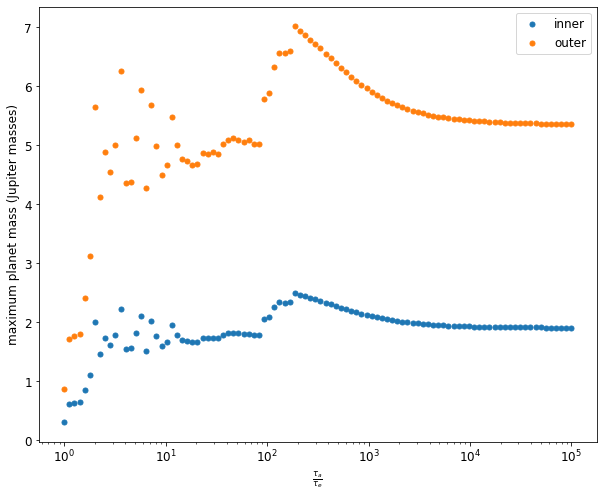

In [57]:
pl.figure(figsize = (10, 8))
pl.scatter(Ks, max_m1s, label = 'inner')
pl.scatter(Ks, max_m2s, label = 'outer')
pl.xscale('log')
pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
pl.legend(loc = 'upper right')

and as a function of eccentricity:

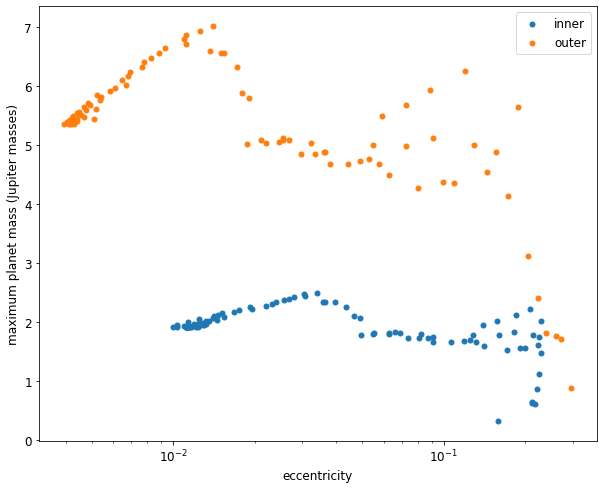

In [58]:
pl.figure(figsize = (10, 8))
pl.scatter(e1_track, max_m1s, label = 'inner')
pl.scatter(e2_track, max_m2s, label = 'outer')
pl.xscale('log')
pl.xlabel(r'eccentricity'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
pl.tick_params(axis='x', which='minor')
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
pl.legend(loc = 'upper right')
pl.show()

Plot $\frac{\tau_a}{\tau_e}$ over the range of $10^0$ to $10^3$ (zoom in especially on the noisy left side) using results from the cluster simulation and see if it looks different:

In [ ]:
# get mass sims for 0 to 10^3

Ks_103 = np.logspace(0, 3, nsims)  # logspace from 10^0 to 10^3

mass_sims_103_location = 'hd_max_mass'  # folder that the mass sims are in
max_m1s_103, max_m2s_103 = np.zeros(len(Ks_103)), np.zeros(len(Ks_103))

for i in range(0, nsims):
    mass_sim_103 = rb.Simulation(f'{mass_sims_location}/max_mass_archive_cluster_103_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim_103.particles[1]
    outer = mass_sim_103.particles[2]
    
    max_m1s_103[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s_103[i] = outer.m * STAR_MASS

# Plot max planet mass:

pl.figure(figsize = (10, 8))
pl.scatter(Ks_103, max_m1s_103, label = 'inner')
pl.scatter(Ks_103, max_m2s_103, label = 'outer')
pl.xscale('log')
pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
pl.legend(loc = 'upper right')

And put the $10^3$ and $10^5$ range graphs on top of each other:

In [ ]:
Ks_combined = np.concatenate((Ks, Ks_103))

max_m1s_combined = np.concatenate((max_m1s, max_m1s_103))
max_m2s_combined = np.concatenate((max_m2s, max_m2s_103))

pl.figure(figsize = (12, 9))
pl.scatter(Ks_combined, max_m1s_combined, label = 'inner')
pl.scatter(Ks_combined, max_m2s_combined, label = 'outer')
pl.xscale('log')
pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
pl.title(r'Maximum planet mass as a function of $\frac{\tau_a}{\tau_e}$')
pl.legend(loc = 'upper right')

Now zoom in on the $K$ bounds (corresponding to the eccentricity track passing through the distribution) we had earlier:

In [ ]:
pl.figure(figsize = (12, 9))
pl.scatter(Ks_combined, max_m1s_combined, label = 'inner')
pl.scatter(Ks_combined, max_m2s_combined, label = 'outer')
# pl.xscale('log')
pl.xlim(K_dist_bounds[0], K_dist_bounds[-1])  # bounds calculated earlier
pl.xlabel(r'$K = \frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
pl.title(r'Maximum planet mass as a function of $K = \frac{\tau_a}{\tau_e}$')
pl.legend(loc = 'upper left')

# K_dist_bounds

Maximum mass is inner planet $m_b \leq 3 M_j$ and outer planet $m_c \leq 7 M_j$ based on the graph between the $K$ values

Test arbitrary values of $K$ to see if everything looks right:

In [ ]:
index = 7

Ks[index], max_m2s[index]

Period, eccentricity, and mean longitude angle plots:

In [ ]:
t_end = 3e5
tau_e_factor = 3
period_ratio = 3/2

k_sim = get_simple_sim(masses)

inner = k_sim.particles[1]  # inner and outer planets in our simulation
outer = k_sim.particles[2]

rebx = reboundx.Extras(k_sim)  # eccentricity and migration forces
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

# tau_e
inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant
tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

# set the semi-major axis damping for inner and outer planets

# tau_a
outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(Ks[index] * tau_e, inner.m, outer.m, period_ratio = period_ratio)  # 3/2 period ratio

k_times = np.linspace(0, t_end, int(1e3))

k_p1, k_p2, k_e1, k_e2, k_angle1, k_angle2 = np.zeros(len(k_times)), np.zeros(len(k_times)), np.zeros(len(k_times)), np.zeros(len(k_times)), np.zeros(len(k_times)), np.zeros(len(k_times))

for i, t in tqdm(enumerate(k_times)):
    k_sim.integrate(t)
    
    phi = 3 * outer.l - 2 * inner.l
    
    k_p1[i], k_p2[i] = inner.P, outer.P
    k_e1[i], k_e2[i] = inner.e, outer.e
    k_angle1[i], k_angle2[i] = phi - inner.pomega, phi - outer.pomega  # mean longitude angle
    
    # takes approximately ~8 minutes to run

Plot:

In [ ]:
k_pr = k_p2/k_p1  # period ratio (outer/inner)

fig, axs = pl.subplots(2, 2, figsize = (10, 8))
axs[0, 0].plot(k_times, k_pr)
axs[0, 0].set_title('period ratio (outer/inner)')
axs[0, 1].plot(k_times, k_e1, label = 'inner')
axs[0, 1].plot(k_times, k_e2, label = 'outer')
axs[0, 1].legend(loc = 'lower right')
axs[0, 1].set_title('eccentricity')
axs[1, 0].scatter(k_times, np.mod(k_angle1, 2 * np.pi), label = 'inner')
axs[1, 0].scatter(k_times, np.mod(k_angle2, 2 * np.pi), label = 'outer')
axs[1, 0].legend()
axs[1, 0].set_title('Mean longitude angle')
pl.tight_layout()
pl.show()
#     axs[1, 1].plot(x, -y, 'tab:red')
#     axs[1, 1].set_title('Axis [1, 1]')

Now do mass growth at the end, to see if it's doing what we want it to:

In [ ]:
# now create a new sim with the equlibirum positions and turn up the masses until there is a close encounter
new_sim = k_sim.copy()

rebx = reboundx.Extras(new_sim)
rebx.add_operator(rebx.load_operator("modify_mass"))

# 1e5 is faster than 1e6 which eats up a lot of time and processing power locally
k_mass_times = np.linspace(k_sim.t, k_sim.t + 3e5, int(1e5))  # try something like this maybe

inner = new_sim.particles[1]
outer = new_sim.particles[2]

k_mass_p1, k_mass_p2, k_mass_e1, k_mass_e2 = np.zeros(len(k_mass_times)), np.zeros(len(k_mass_times)), np.zeros(len(k_mass_times)), np.zeros(len(k_mass_times))

inner.params['tau_mass'], outer.params['tau_mass'] = 1e5, 1e5
new_sim.exit_min_distance = 5 * inner.rhill  # 5 times the hill distance as a close encounter

# print(k_mass_times)
for i, t in tqdm(enumerate(k_mass_times)):
    try:
        new_sim.integrate(t)
    except rb.Encounter as error:  # breaks loop if close encounter
        print('Close encounter!')
        break
    k_mass_p1[i], k_mass_p2[i] = inner.P, outer.P
    k_mass_e1[i], k_mass_e2[i] = inner.e, outer.e

# max masses
k_max_m1 = inner.m * STAR_MASS
k_max_m2 = outer.m * STAR_MASS

# since masses are jupiter masses/star masses 
# to get the max masses in jupiter masses

In [ ]:
mass_pr = k_mass_p2/k_mass_p1  # period ratio

fig, axs = pl.subplots(2, 1, figsize=(10, 7))
axs[0].plot(k_mass_times, mass_pr)
axs[0].set_title('period ratio (outer/inner)')
axs[1].plot(k_mass_times, k_mass_e1, label = 'inner')
axs[1].plot(k_mass_times, k_mass_e2, label = 'outer')
axs[1].legend(loc = 'upper right') 
axs[1].set_title('eccentricity')
pl.tight_layout()
pl.show()
# axs[1, 0].scatter(k_mass_times, np.mod(k_angle1, 2 * np.pi))
# axs[1, 0].scatter(k_mass_times, np.mod(k_angle2, 2 * np.pi))
# axs[1, 0].set_title('Mean longitude angle')
#     axs[1, 1].plot(x, -y, 'tab:red')
#     axs[1, 1].set_title('Axis [1, 1]')

Check if close enough to upper bound above:

In [ ]:
max_m2s[index], k_max_m2

So we have lower, upper bounds on the planet masses of (using the min $\chi^2$ result for the $\sin(i)$ grid search fit as the minimum mass since we're assuming the inclination is $\frac{\pi}{2}$):

In [ ]:
print(f'minimum mass of inner planet: {masses[0] * STAR_MASS} Jupiter masses\nminimum mass of outer planet: {masses[1] * STAR_MASS} Jupiter masses')
print(f'maxmimum mass of inner planet: {max(max_m1s_combined)} Jupiter masses\nmaximum mass of outer planet: {max(max_m2s_combined)} Jupiter masses')

Inner one has mass between $\sim0.201 M_j \leq m_b \leq\,\sim2.622 M_j$ and outer one has mass between $\sim0.564 M_j \leq m_c \leq\,\sim7.373 M_j$, probably closer to the lower bounds based on $\chi^2$

Check MMR angle plots:

In [ ]:
K = Ks[2]  # arbitrary

tau_e_factor = 3
t_end = 3e5

In [ ]:
sim = get_simple_sim(masses)

inner = sim.particles[1]  # inner and outer planets in our simulation
outer = sim.particles[2]

rebx = reboundx.Extras(sim)  # eccentricity and migration forces
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

# tau_e
inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant
tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

# set the semi-major axis damping for inner and outer planets

# tau_a
outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m, period_ratio = 3/2)  # 3/2 period ratio

sim.integrate(t_end) # integrate to t_end to find the equilibrium eccentricities

# now create a new sim with the equlibirum positions and turn up the masses until there is a close encounter
new_sim = sim.copy()

times = np.linspace(new_sim.t, new_sim.t + 10000, 1000)
e1s, e2s, angle1, angle2 = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

inner = new_sim.particles[1]
outer = new_sim.particles[2]

for i, t in tqdm(enumerate(times)):
    new_sim.integrate(t)    
    e1s[i], e2s[i] = inner.e, outer.e
    phi = 3 * outer.l - 2 * inner.l
    angle1[i], angle2[i] = phi - inner.pomega, phi - outer.pomega  # mean longitude angle


Plot:

In [ ]:
pl.scatter(times, np.mod(angle1, 2 * np.pi), label = 'inner')
pl.scatter(times, np.mod(angle2, 2 * np.pi), label = 'outer')
pl.legend()

### $10^2$ stuff (not needed right now so commented out):

Weirdness happening around $10^2$, see what happens if I zoom in

In [ ]:
# Ks_102 = np.linspace(65, 90, nsims)
# filename_102 = 'max_mass_archive_102_cluster.bin'

Only run this if i need to reinitialize all the mass simulations again:

In [ ]:
# max_m1s_102, max_m2s_102 = get_max_masses(planet_masses, Ks_102, period_ratio = 3/2, filename = filename_102)

Run this:

In [ ]:
# mass_archive_102 = rb.SimulationArchive(filename_102)
# max_m1s_102, max_m2s_102 = np.zeros(len(mass_archive_102)), np.zeros(len(mass_archive_102))

# for i in range(0, len(mass_archive_102)):
#     mass_sim_102 = mass_archive_102[i]
#     inner = mass_sim_102.particles[1]  # inner and outer planets in each simulation
#     outer = mass_sim_102.particles[2]
    
#     max_m1s_102[i] = inner.m * STAR_MASS
#     max_m2s_102[i] = outer.m * STAR_MASS

Plot this zoomed in version as well (jump happens between $68$ and $87$)

In [ ]:
# pl.figure(figsize = (10, 8))
# pl.scatter(Ks, max_m1s, label = 'inner')
# pl.scatter(Ks, max_m2s, label = 'outer')
# # pl.xscale('log')
# pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
# pl.xlim(0, 200)
# pl.legend(loc = 'upper right')

In [ ]:
# pl.figure(figsize = (10, 8))
# pl.scatter(Ks_102, max_m1s_102, label = 'inner')
# pl.scatter(Ks_102, max_m2s_102, label = 'outer')
# # pl.xscale('log')
# pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
# pl.legend(loc = 'upper right')